In [39]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [40]:
# the order and colors
name = ['LastFM', 'ML', 'Yelp', 'Beauty']
colors = ['#262bc7', '#9b29a6','#217a23', '#c79726']
models = ['SASRec', 'BERT4Rec', 'BSARec']

In [ ]:
data_whole = # path to item embeddings and use oie.npz
data_binned = # path to item embeddings and use oie_bins.npz

In [42]:
data_whole_np = np.load(data_whole)
data_binned_np = np.load(data_binned)

In [43]:
data_whole_np.files

['SA', 'AAE']

In [44]:
data_binned_np.files

['SA_bins', 'AAE_bins']

In [45]:
sa_whole = data_whole_np['SA'] # shape is (3,4)
aae_whole = data_whole_np['AAE']

In [46]:
sa_bins = data_binned_np['SA_bins'] # shape is (3,4,2)
aae_bins = data_binned_np['AAE_bins']

In [47]:
# OIE Metric, also in utils/metric.py
from itertools import combinations
class OIEMetric:
    '''
    Takes the item embeddings and then measures the AAE and SA
    '''
    def __init__(self, Z):
        self.Z = Z
        self.N = Z.shape[0]
        self.idx_pair_list = self.idx_pair_func() # get the pairwise of index
        self.max_dist = 0
        self.max_dist_func() # get the max distance

    def idx_pair_func(self):
        # get the combinations of two items
        idx_pair_list = list(combinations(range(self.N), 2))
        return idx_pair_list
    
    def dist_pair(self, x,y):
        return np.linalg.norm(x-y)
    
    def max_dist_func(self):
        for idx_pair in self.idx_pair_list:
            dist = self.dist_pair(self.Z[idx_pair[0]], self.Z[idx_pair[1]])
            if dist > self.max_dist:
                self.max_dist = dist

    def dist_pair_norm(self, x,y):
        return np.linalg.norm(x-y) / self.max_dist
    
    def AAE(self):
        # average absolute error
        aae = []
        for i in range(self.N - 1):
            aae.append(self.dist_pair_norm(self.Z[i], self.Z[i+1]))
        return np.mean(aae)
    
    def ordered_id_cond(self, zs, idxs):
        if len(idxs) != 3:
            raise ValueError("The length of the index should be 3")
        # fetch
        i, j, k = idxs[0], idxs[1], idxs[2]
        zi, zj, zk = zs[0], zs[1], zs[2]
        state = False # normally false
        # distance
        dij = self.dist_pair_norm(zi, zj)
        djk = self.dist_pair_norm(zj, zk)
        dik = self.dist_pair_norm(zi, zk)
        # print(dij, djk, dik)
        # constraint, just to make sure.q1
        if i>j or j>k or i>k:
            return state
        if i < j and j < k and i < k:
            if dij < dik and djk < dik:
                state = True
        return state
    
    def SA(self):
        # sequential adjacency
        sa = []
        for i in range(self.N - 2):
            sa.append(self.ordered_id_cond([self.Z[i], self.Z[i+1], self.Z[i+2]], [i, i+1, i+2]))
        return np.mean(sa)
     

In [48]:
# random part
torch.manual_seed(2025)
oie_metric_random = OIEMetric(torch.nn.Embedding(5000, 64).weight.data.clone().cpu().numpy())
SA_random_bins, AAE_random_bins = oie_metric_random.SA(), oie_metric_random.AAE()

In [50]:
# normalization to the random 
norm = lambda x, sa_rand: (np.array(x) - sa_rand)* 100 / sa_rand 

# normalize it by using map()
deltasa_bins_norm = []
for i in range(3):
    sa_bins_norm_j = []
    for j in range(4):
        sa_bins_norm_j.append(list(map(norm, sa_bins[i][j], [SA_random_bins]*4)))
    deltasa_bins_norm.append(sa_bins_norm_j)

deltaaae_bins_norm = []
for i in range(3):
    aae_bins_norm_j = []
    for j in range(4):
        aae_bins_norm_j.append(list(map(norm, aae_bins[i][j], [AAE_random_bins]*4)))
    deltaaae_bins_norm.append(aae_bins_norm_j)
print(deltasa_bins_norm)

[[[41.52079901153213, 16.055897998817873], [17.256825457660746, 15.604510274435585], [29.801355658819467, 22.45354324282808], [42.9555465302593, 15.695180067906962]], [[10.286073524444816, 7.813291606856369], [8.918100243341895, 11.20555630661079], [13.666159414724069, 19.41252169605554], [11.375231284255504, 11.257529402415765]], [[35.58286338867064, 18.858384172084772], [13.207415569483281, 13.668970528592672], [36.84925736395407, 25.392668209224627], [37.74181523964547, 20.85925677480067]]]


In [51]:
# for the whole data
deltasa_whole_norm = []
for i in range(3):
    deltasa_whole_norm.append(list(map(norm, sa_whole[i], [SA_random_bins]*4)))
deltaaae_whole_norm = []
for i in range(3):
    deltaaae_whole_norm.append(list(map(norm, aae_whole[i], [AAE_random_bins]*4)))
print(deltasa_whole_norm)

[[28.87899651788541, 16.450191463002593, 26.129850892418286, 29.30398720597585], [9.072244609477202, 9.997389265447667, 16.52784924105995, 11.29797759879985], [27.230927508705292, 13.459778691294071, 31.10787163615139, 29.27916401780038]]


<>:96: SyntaxWarning: invalid escape sequence '\D'
<>:97: SyntaxWarning: invalid escape sequence '\D'
<>:96: SyntaxWarning: invalid escape sequence '\D'
<>:97: SyntaxWarning: invalid escape sequence '\D'
/var/folders/dv/789rlrv9705cb4xh_x3cvnhw0000gn/T/ipykernel_38166/3962007758.py:96: SyntaxWarning: invalid escape sequence '\D'
  axs[0, 0].set_ylabel('$\Delta SA$ (%)', fontsize=25)
/var/folders/dv/789rlrv9705cb4xh_x3cvnhw0000gn/T/ipykernel_38166/3962007758.py:97: SyntaxWarning: invalid escape sequence '\D'
  axs[1, 0].set_ylabel('$\Delta AAE$ (%)', fontsize=25)


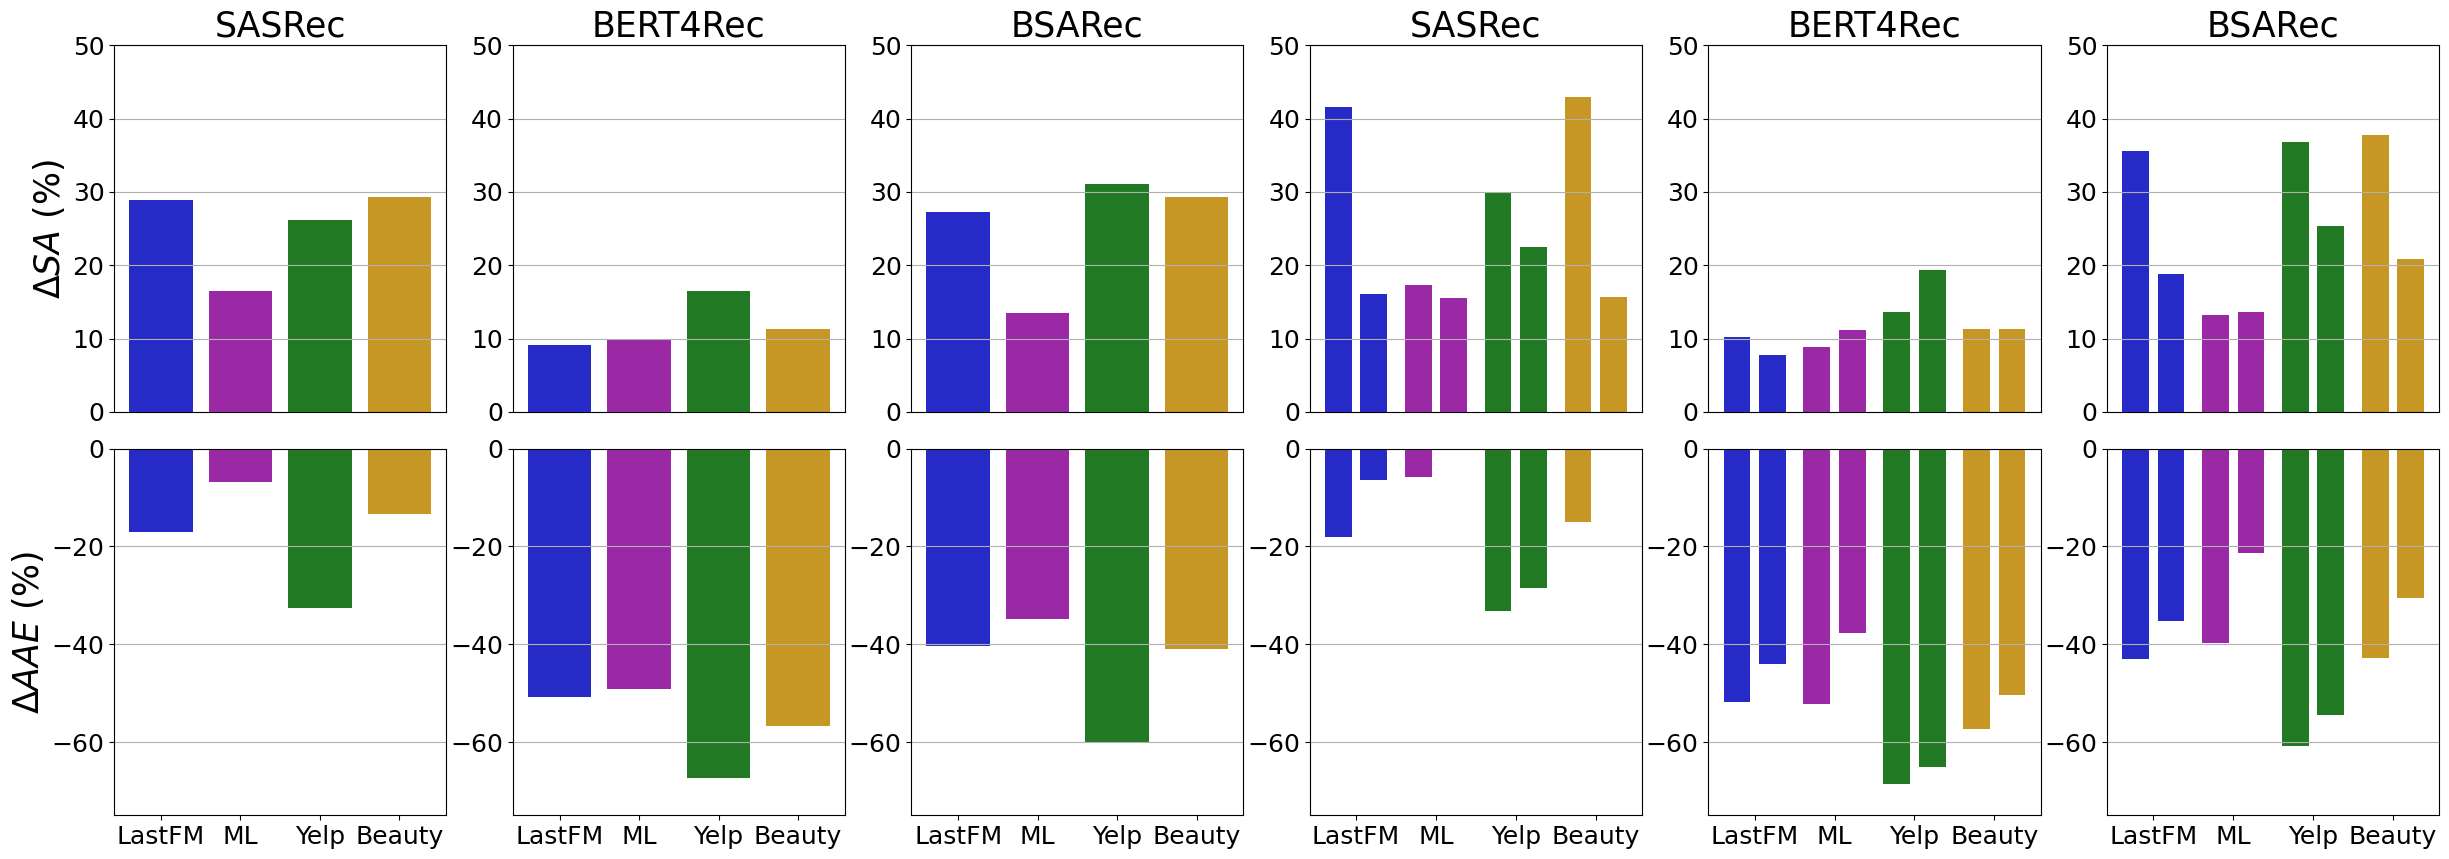

In [ ]:
# plotting with 6 columns and 2 rows subplots
fig, axs = plt.subplots(2, 6, figsize=(30, 10))

# the first row is for DeltaSA score
# the second row is for DeltaAAE score
# the first three columns are for the whole data
# the last three columns are for the binned data

# the first row
for i in range(3):
    axs[0, i].bar(np.arange(4), deltasa_whole_norm[i], color=colors)
    axs[0, i].set_xticks([])
    # axs[0, i].set_xticklabels(name)
    axs[0, i].set_title(models[i], fontsize=25)
    axs[0, i].set_ylim([0, 50])
    # axs[0, i].set_xlabel('Datasets')
    # axs[0, i].set_ylabel('DeltaSA')
    axs[0, i].grid(axis='y')
    # increase the ytick label size
    axs[0, i].tick_params(axis='y', labelsize=18)
# the second row
for i in range(3):
    axs[1, i].bar(np.arange(4), deltaaae_whole_norm[i], color=colors)
    axs[1, i].set_xticks(np.arange(4), name, fontsize=18)
    axs[1, i].set_xticklabels(name)
    # axs[1, i].set_title(models[i])
    axs[1, i].set_ylim([-75,0])
    # axs[1, i].set_xlabel('Datasets')
    # axs[1, i].set_ylabel('DeltaAAE')
    axs[1, i].grid(axis='y')
    axs[1, i].tick_params(axis='y', labelsize=18)
# the last three columns, binned data, need to use offset so the first bin is adjacent to the second bin
small_gap = 0.1  # the width of the bars
wide_gap = 0.15
num_bins=2
x = [0]# starts from zero
for i in range(len(name)*num_bins-1):
    if i+1 % num_bins == 0:
        x.append(x[-1]+ wide_gap)
    else:
        x.append(x[-1]+ small_gap)
for n in range(3):
    offset = 0
    counter=0
    new_x = []
    for m in range(4): # data set
        for i in range(2):
            rects = axs[0][n+3].bar(x[counter]+ offset, deltasa_bins_norm[n][m][i], wide_gap, color=colors[m])
            new_x.append(x[counter] + offset)
            counter += 1
            if i == num_bins-1:
                offset += wide_gap
            else:
                offset += small_gap

    axs[0, n+3].set_xticks([])
    # axs[0, n+3].set_xticklabels(name)
    axs[0, n+3].set_title(models[n], fontsize=25)
    axs[0, n+3].set_ylim([0, 50])
    # axs[0, n+3].set_xlabel('Datasets')
    # axs[0, n+3].set_ylabel('DeltaSA')
    axs[0, n+3].grid(axis='y')
    # increase the ytick label size
    axs[0, n+3].tick_params(axis='y', labelsize=18)
# the second row, AAE
for n in range(3):
    offset = 0
    counter=0
    new_x = []
    for m in range(4): # data set
        for i in range(2):
            rects = axs[1][n+3].bar(x[counter]+ offset, deltaaae_bins_norm[n][m][i], wide_gap, color=colors[m])
            new_x.append(x[counter] + offset)
            counter += 1
            if i == num_bins-1:
                offset += wide_gap
            else:
                offset += small_gap

    axs[1, n+3].set_xticks(np.array(new_x)[::2] + wide_gap-small_gap/2, name, fontsize=18)
    # axs[1, n+3].set_xticklabels(name)
    # axs[1, n+3].set_title(models[n])
    axs[1, n+3].set_ylim([-75,0])
    # axs[1, n+3].set_xlabel('Datasets')
    # axs[1, n+3].set_ylabel('DeltaAAE')
    axs[1, n+3].grid(axis='y')
    # axs[1, n+3].set_yticklabels([], fontsize=18, rotation=0,)
    # give a consistent number of grid lines
    axs[1, n+3].tick_params(axis='y', labelsize=18)



# decrease the gap between the two rows
plt.subplots_adjust(hspace=0.1)

axs[0, 0].set_ylabel('$\Delta SA$ (%)', fontsize=25)
axs[1, 0].set_ylabel('$\Delta AAE$ (%)', fontsize=25)

plt.savefig('fig3.pdf',dpi=450, bbox_inches='tight')